In [1]:
import netket
from flax.core.scope import CollectionFilter
from netket.utils.types import PyTree
from netket.operator import Squared
from functools import partial, lru_cache
from typing import Callable, Optional
##
import jax
from jax import numpy as jnp
from flax.core.scope import CollectionFilter, DenyList  # noqa: F401

import netket as nk
from netket import jax as nkjax
from netket.operator import DiscreteOperator, Squared
from netket.stats import Stats
from netket.utils.types import PyTree
from netket.utils.dispatch import dispatch

# from nektet.vqs import _ex
from netket.vqs import expect_and_grad, expect_and_forces
from netket.vqs.mc.common import force_to_grad
from netket.stats import Stats
import time
import json
import matplotlib.pyplot as plt
import numpy as np
from netket.operator.spin import sigmax, sigmay,sigmaz

In [3]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
# Define a 1d chain
L = 4
dis = 1
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
# ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
b=dis
a=-dis
Gamma = (b-a) * np.random.random_sample(L) + a

################################################################################
################################################################################
################################################################################
#이렇게 정의하는게 더 빨랑
ha = sum([ sigmax(hi,i)*sigmax(hi,(i+1)%L)
         + sigmay(hi,i)*sigmay(hi,(i+1)%L)
         + sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
           for i in range(L)])
################################################################################
################################################################################
################################################################################
ha = ha + sum([Gamma[i]*sigmaz(hi,i) for i in range(L)])

In [4]:
Et = np.random.uniform(low=0, high=L, size=None)
Et

2.996426219506861

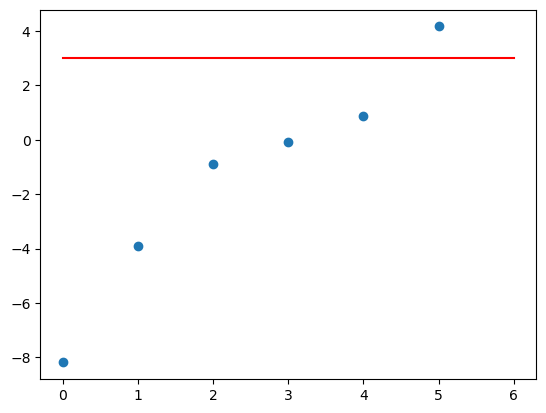

In [5]:
E, vec = np.linalg.eigh(ha.to_dense())
plt.scatter(range(len(E)),E)
plt.plot([0,len(E)],[Et,Et],'r')

In [6]:
E

array([-8.19030134, -3.88782302, -0.90066678, -0.07971255,  0.8888575 ,
        4.16964619])

In [7]:
ha_Et_inv  = np.linalg.inv((ha-Et).to_dense())
E_inv, vec_inv = np.linalg.eigh(ha_Et_inv)

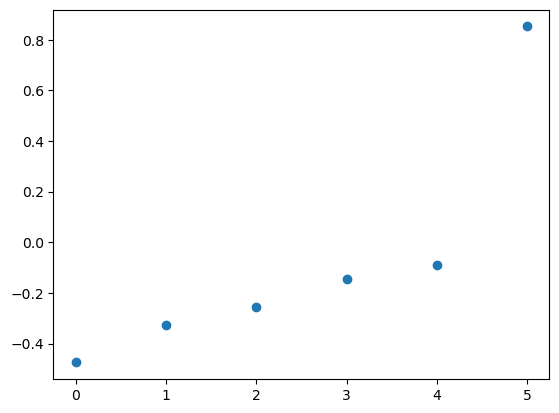

In [8]:
plt.scatter(range(len(E_inv)),E_inv)

In [97]:
E_inv
# -4.135835

array([-5.47347905, -3.93696883, -1.60319515, -1.45120597, -0.99340303,
       -0.83801642, -0.73172481, -0.68539421, -0.54227716, -0.51492118,
       -0.44639857, -0.41849175, -0.4029607 , -0.38094775, -0.30338203,
       -0.29987219, -0.27979025, -0.27410867, -0.25581434, -0.25058533,
       -0.24813256, -0.23502829, -0.22569264, -0.21676221, -0.19346707,
       -0.18565508, -0.18231569, -0.17880933, -0.17120588, -0.1681469 ,
       -0.16379992, -0.15816302, -0.143205  , -0.14249073, -0.13780707,
       -0.13267026, -0.12738017, -0.11341057, -0.11109425, -0.10868111,
       -0.10643321, -0.10404844, -0.10025839, -0.09696792, -0.08944062,
       -0.0887004 , -0.08170605, -0.08035389, -0.07270966, -0.06703696,
       -0.05785724,  0.16574424,  0.20362904,  0.20823723,  0.23791401,
        0.24864294,  0.25595635,  0.30075264,  0.30662658,  0.32083034,
        0.35544946,  0.42889952,  0.43807377,  0.47892316,  0.53216934,
        0.77581784,  0.82668911,  0.97534508,  2.10177667,  3.87

In [98]:
def add(x,y):
    return x+y


In [99]:
@nk.vqs.expect.dispatch
def expect_try(vstate: nk.vqs.FullSumState, Ô: nk.operator.DiscreteOperator) -> Stats:  # noqa: F811
#     _check_hilbert(vstate, Ô)

#     O = sparsify(Ô)
    O = Ô.to_sparse()
    Ψ = vstate.to_array()

    # TODO: This performs the full computation on all MPI ranks.
    # It would be great if we could split the computation among ranks.

    OΨ = O @ Ψ
    expval_O = (Ψ.conj() * OΨ).sum() 

    variance = jnp.sum(jnp.abs(OΨ - expval_O * Ψ) ** 2)
    return Stats(mean=expval_O, error_of_mean=0.0, variance=variance)

In [100]:
O_sparse = ha.to_sparse()
H_Et_sparse = (ha-Et).to_sparse()
H_Et_squ_sparse = ((ha-Et)@(ha-Et)).to_sparse()

In [101]:
@expect_and_grad.dispatch
def expect_and_grad_fullsum(
    vstate: nk.vqs.FullSumState,
    Ô: nk.operator.DiscreteOperator,
    *args,
    mutable: CollectionFilter = False,
    use_covariance: Optional[bool] = None,
    **kwargs,
) -> tuple[Stats, PyTree]:
    if use_covariance is None:
        use_covariance = Ô.is_hermitian

    if use_covariance:
        # Implementation of expect_and_grad for `use_covariance == True` (due to the Literal[True]
        # type in the signature).` This case is equivalent to the composition of the
        # `expect_and_forces` and `force_to_grad` functions.
        # return expect_and_grad_from_covariance(vstate, Ô, *args, mutable=mutable)
        Ō, Ō_grad = expect_and_forces(vstate, Ô, *args, mutable=mutable, **kwargs)
        Ō_grad = force_to_grad(Ō_grad, vstate.parameters)
        return Ō, Ō_grad
    else:
        raise NotImplementedError(
            "The gradient of non hermitian operators with "
            "FullSumState is not yet implemented"
        )

@nk.vqs.expect_and_forces.dispatch
def expect_and_forces_fullsum(
    vstate: nk.vqs.FullSumState,
    Ô: nk.operator.DiscreteOperator,
    *,
    mutable: CollectionFilter = False,
) -> tuple[Stats, PyTree]:
    if isinstance(Ô, Squared):
        raise NotImplementedError("expect_and_forces not yet implemented for `Squared`")

#     _check_hilbert(vstate, Ô)
    

    O = O_sparse
    H_Et = H_Et_sparse
    H_Et_squ = H_Et_squ_sparse

    Ψ = vstate.to_array()
    OΨ = O @ Ψ
    H_EtΨ = H_Et@Ψ
    H_Et_squΨ = H_Et_squ @ Ψ
    Ψ_pre = H_Et @ Ψ
    Ψ_pre = Ψ_pre / jnp.linalg.norm(Ψ_pre)
    H_EtΨ_pre = H_Et @ Ψ_pre
    invOΨ = ha_Et_inv @ Ψ
    Ψ_pre_conjO = Ψ_pre.conj() @ H_Et

    expval_O, Ō_grad, new_model_state = _exp_forces(
        vstate._apply_fun,
        mutable,
        vstate.parameters,
        vstate.model_state,
        vstate._all_states,
        OΨ,
        Ψ,
        Ψ_pre,
        H_Et_squΨ,
        H_EtΨ,
        H_EtΨ_pre,
        invOΨ,
        Ψ_pre_conjO,
    )

    if mutable is not False:
        vstate.model_state = new_model_state

    return expval_O, Ō_grad


@partial(jax.jit, static_argnums=(0, 1))
def _exp_forces(
    model_apply_fun: Callable,
    mutable: CollectionFilter,
    parameters: PyTree,
    model_state: PyTree,
    σ: jnp.ndarray,
    OΨ: jnp.ndarray,
    Ψ: jnp.ndarray,
    Ψ_pre: jnp.ndarray,
    H_Et_squΨ: jnp.ndarray,
    H_EtΨ: jnp.ndarray,
    H_EtΨ_pre: jnp.ndarray,
    invOΨ: jnp.ndarray,
    Ψ_pre_conjO: jnp.ndarray,
) -> tuple[PyTree, PyTree]:
    is_mutable = mutable is not False

    expval_O = (Ψ.conj() * invOΨ).sum()
#     expval_O = (Ψ.conj() * OΨ).sum()
    variance = jnp.sum(jnp.abs(OΨ - expval_O * Ψ) ** 2)
    ΔOΨ = (OΨ - expval_O * Ψ).conj() * Ψ
    
    expval_H_Et_squ = (Ψ.conj() * H_Et_squΨ).sum()
    ΔOΨ_squ = (H_Et_squΨ - expval_H_Et_squ * Ψ).conj() * Ψ
    
    denom = Ψ_pre.conj()@Ψ
    expval_H_Et = (Ψ_pre.conj() * H_EtΨ).sum()/denom
    ΔOΨ_non = (Ψ_pre_conjO - expval_H_Et * Ψ_pre.conj())/denom * Ψ
#     ΔOΨ_non = (Ψ_pre_conjO - expval_H_Et * Ψ_pre.conj()) * Ψ
#     ΔOΨ_non = (H_EtΨ_pre - expval_H_Et * Ψ_pre).conj() * Ψ
    

    
    _, vjp_fun, *new_model_state = nkjax.vjp(
        lambda w: model_apply_fun({"params": w, **model_state}, σ, mutable=mutable),
        parameters,
        conjugate=True,
        has_aux=is_mutable,
    )

#     Ō_grad = vjp_fun(ΔOΨ)[0]
    Ō_grad_first = vjp_fun(ΔOΨ_squ)[0]
    Ō_grad_second = vjp_fun(-2*ΔOΨ_non)[0]
#     Ō_grad_second = vjp_fun(ΔOΨ_non)[0]
    
    Ō_grad = jax.tree_map(add, Ō_grad_first, Ō_grad_second)
#     Ō_grad = Ō_grad_first

    new_model_state = new_model_state[0] if is_mutable else None

    return (
        Stats(mean=expval_O, error_of_mean=0.0, variance=variance),
        Ō_grad,
        new_model_state,
    )

In [102]:
def variance(vsta, hamiltonian):
    return vsta.to_array().conj()@(hamiltonian@hamiltonian).to_sparse()@vsta.to_array() - (vsta.to_array().conj()@(hamiltonian).to_sparse()@vsta.to_array())**2

100%|█| 50000/50000 [03:15<00:00, 256.37it/s, Energy=-5.473e+00+2.168e-18j ± 0.0


Vaiance :  3.3646641031559454e-05
Variational result :  -5.473288493829318
Real result :  -5.473479050469636


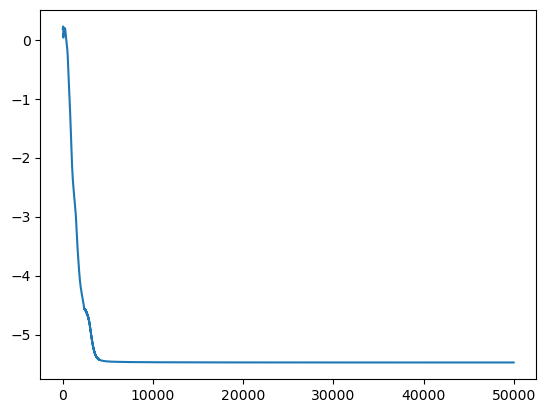

In [107]:
# Build the sampler
# sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)
epochs = 50000


ma = nk.models.RBM(alpha=2, param_dtype=complex)
vs = nk.vqs.FullSumState(hi, ma)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.001)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)


# The ground-state optimization loop
Target_ha = ha
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(epochs, out='RBM')
end = time.time()

data=json.load(open("RBM.log"))
plt.plot(data['Energy']['Mean']['real'])
print("Vaiance : ",variance(vs, ha).real)
print("Variational result : ",data['Energy']['Mean']['real'][-1])
print("Real result : ",E_inv[0])
# plt.plot(np.log10(data['Energy']['Variance']))

In [ ]:
#